![image](https://www.technotification.com/wp-content/uploads/2018/09/Renewable-Energy-Ideas-1200x600.jpg)
Image source: [technotification](https://www.technotification.com/2018/09/amazing-renewable-energy-ideas.html)

This notebook aims to predict a building's energy consumption over 2017 and 2018 using the data from 2016 in 4 different consumpiton categories (electricity, chilled water, steam, hot water) using ASHRAE data, which is our problem statement as well.

This is a supervised machine learning model, meaning based on the columns available in the datasets and data from 2016, we are going to train the model to predict an energy consumption of a building in each category. Since, consumption values are labeled as meter_reading and they are continuous, we are going to apply regression techniques to generate predictions on meter_reading.

It is a highly debated and popular competition in Kaggle currently, however my main motivation is to contribute to make energy-efficient buildings by estimating its energy consumption. It seemed like a good start to save our energy for future!

There will be 3 notebooks covering the complete machine learning building pipeline. 
* [Notebook 1](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-1-detailed-eda) covered understanding, formating the data and detailed EDA. 
* [Notebook 2](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm) consists of the feature engineering, building the model and tuning its parameters.

This third and last notebook will focus on parts 6, 7 and 8 focusing on generating predictions, evaluating them and a summary about the whole project.

1) Understand, Cleand and Format Data

2) Exploratory Data Analysis

3) Feature Engineering & Selection

4) Compare Several Machine Learning Models

5) Perform Hyperparameter Tuning and Cross Validation

**6) Evaluate Model with Test Data**

**7) Interpret Model Results**

**8) Summary & Conclusions**

Machine Learning application and building is not a linear and one time process. Steps above enable me to follow a structured way for an end-to-end machine project flow and preparation for the each step ahead. All in all, steps might be modified or revisited according to findings. You can use the table of contents to navigate to each section. 👇

Enjoy reading !

# <a id = 'top'> Table of Contents </a>
  - <a href = '#1'> Quick Recap from Previous Notebook </a>
  - <a href = '#6'> 6. Evaluate Model with Test Data </a>
    - <a href = '#6-1'> 6.1. Load training data for re-creating model </a>
    - <a href = '#6-2'> 6.2. Build model </a>
    - <a href = '#6-3'> 6.3. Feature alignment between training and test set & Imputation </a>
      - <a href = '#6-3-1'> 6.3.1. Building features transformation </a>
      - <a href = '#6-3-2'> 6.3.2. Weather features transformation </a>
      - <a href = '#6-3-3'> 6.3.3. Create one test dataframe </a>
      - <a href = '#6-3-4'> 6.3.4. Split test data for 2017 and 2018 </a>
      - <a href = '#6-3-5'> 6.3.5. Impute missing values </a>
    - <a href = '#6-4'> 6.4. Make sure test data shape and check for missing values </a>
    - <a href = '#6-5'> 6.5. Generate predictions </a>
  - <a href = '#7'> 7. Interpret Model Results </a>
  - <a href = '#8'> 8. Submissions & Summary & Conclusions </a>

In [ ]:
# for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# pandas options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.use_inf_as_na', True)
pd.options.mode.chained_assignment = None

# for date manipulation
from datetime import datetime

# for visualization: matplotlib
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
# to display visuals in the notebook

# for visualization: seaborn
import seaborn as sns
sns.set_context(font_scale=2)

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from sklearn.model_selection import KFold

# for building the model and calculate RMSE
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt

# to cleanup memory usage
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
## Function to reduce the DF size and reduce test dataframe size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# <a id = '1'> Quick Recap from Previous Notebook </a>
<a href = '#top'> Back to top </a>

In the previous notebook, we focused on feature engineering, building model and improving the evaluation metric (RMSE) further with cross validation and hyperparameter optimization.

With feature engineering, we extracted and transformed features from the existing columns, added features by combining weather variables. Afterwards, with a univariate feature selection method, looking at the pearson coefficients of the features to the log1p of the meter_reading, we determined on final 24 features.

For model selection, linear regression, k nearest neighbor regressor and light gradient boosting models are built. Light gbm delivered the best results. After applying the cross-validation results RMSE improved from 1.21 to 1.1, hyperparameter search did not help much in improving the results. 

**Here is a visual from how training and validation error improved in from one of the cross-validation folds of Light GBM:**
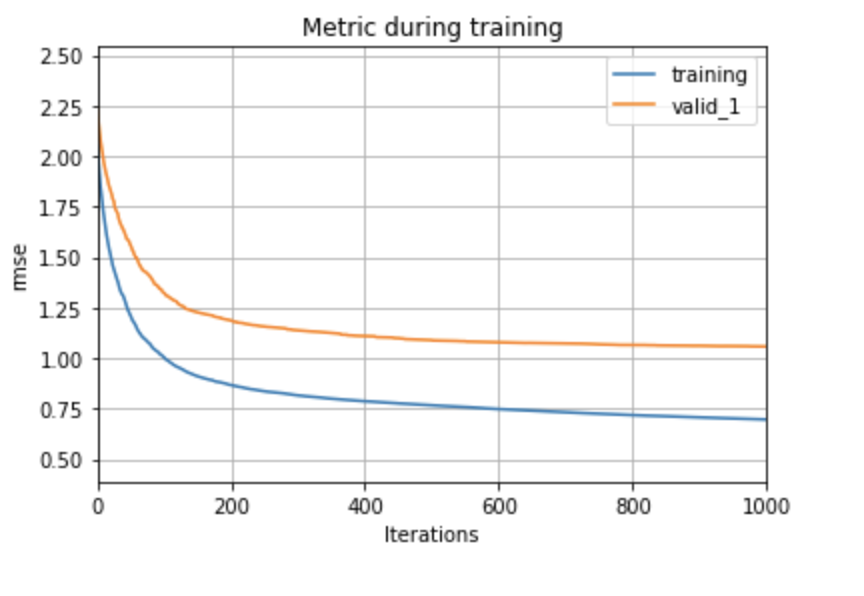

I will perform same steps performed in the feature engineering to align test set with the training set. With the cross validated model I will generate the predictions and evaluate them.

Finally, I will end the project with an overall summary.

# <a id = '6'> 6. Evaluate Model with Test Data </a>
<a href = '#top'> Back to top </a>

## <a id = '6-1'> 6.1. Load training data for re-creating model </a>
<a href = '#top'> Back to top </a>

In [ ]:
# load training data created in the second notebook into dataframes
X = pd.read_csv("/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/X.csv")
y = pd.read_csv("/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/y.csv", header=None)

reduce_memory_usage(X)
reduce_memory_usage(y)

In [ ]:
# rename target as log_meter_reading
y.rename(columns = {0: "log_meter_reading"}, 
         inplace=True)

## <a id = '6-2'> 6.2. Build model </a>
<a href = '#top'> Back to top </a>

In [ ]:
# create categorical features 
categorical_features = ['building_id', 'site_id', 'meter',
                        'primary_use', 'wind_compass_direction',
                        'day_of_week', 'hour','is_weekend', 'season']

# initial parameters of light gbm algorithm
initial_params = {"objective": "regression",
                  "boosting": "gbdt",
                  "num_leaves": 60,
                  "learning_rate": 0.05,
                  "feature_fraction": 0.85,
                  "reg_lambda": 2,
                  "metric": {'rmse'}
}

In [ ]:
# cretae kfold object and empty model and evaluation lists
kf = KFold(n_splits=4, shuffle=False, random_state=42)

# save 4 model as a list
models = []

# dynamically split X and y with the k-fold split indexes
for train_index,valid_index in kf.split(X):
    X_train_kf = X.loc[train_index]
    y_train_kf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_kf, 
                          label=y_train_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    d_valid = lgb.Dataset(X_valid_kf, 
                          label=y_valid_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    model = lgb.train(initial_params, 
                      train_set=d_train, 
                      num_boost_round=1000, 
                      valid_sets=[d_train, d_valid],
                      verbose_eval=250, 
                      early_stopping_rounds=500)
    
    models.append(model)
    
    del X_train_kf, y_train_kf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

## <a id = '6-3'> 6.3. Feature alignment between training and test set & Imputation </a>
<a href = '#top'> Back to top </a>

Let's have a look at the columns of X and align accordingly

In [ ]:
X.columns

In [ ]:
del X
del y
gc.collect()

In [ ]:
# load building  data modify
building = pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv")
# drop floor_count
building.drop(columns=["floor_count"], inplace=True)

# load weather_test modify
weather_test = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_test.csv")
weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"],
                                            format='%Y-%m-%d %H:%M:%S')

# load test and modify
test = pd.read_csv("/kaggle/input/ashrae-energy-prediction/test.csv")
test["timestamp"] = pd.to_datetime(test["timestamp"],
                                   format='%Y-%m-%d %H:%M:%S')

reduce_memory_usage(building)
reduce_memory_usage(weather_test)
reduce_memory_usage(test)

### <a id = '6-3-1'> 6.3.1. Building features transformation </a>
<a href = '#top'> Back to top </a>

In [ ]:
# add building age column
current_year = datetime.now().year
building['building_age'] = current_year - building['year_built']
building.drop(columns=['year_built'], inplace=True)

# since NA values only present in building age fillna can be used
building.fillna(round(building.building_age.mean(),0),
                inplace=True)

In [ ]:
# create label encoder object and transform the column
le = LabelEncoder()
le_primary_use = le.fit_transform(building.primary_use)

# add label encoded column to dataframe
building['primary_use'] = le_primary_use

del le, le_primary_use
gc.collect()

In [ ]:
# check if any NA values left
building.isna().sum()

### <a id = '6-3-2'> 6.3.2. Weather features transformation </a>
<a href = '#top'> Back to top </a>

In [ ]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

In [ ]:
# add month, day of week, day of month, hour, season
weather_test['month'] = weather_test['timestamp'].dt.month.astype(np.int8)
weather_test['day_of_week'] = weather_test['timestamp'].dt.dayofweek.astype(np.int8)
weather_test['day_of_month']= weather_test['timestamp'].dt.day.astype(np.int8)
weather_test['hour'] = weather_test['timestamp'].dt.hour
weather_test['season'] = weather_test.month.apply(convert_season)

# add is weekend column
weather_test['is_weekend'] = weather_test.day_of_week.apply(lambda x: 1 if x>=5 else 0)

**Reset Index for Update**

In [ ]:
# reset index for fast update
weather_test = weather_test.set_index(
    ['site_id','day_of_month','month'])

**Air Temperature**

In [ ]:
# create dataframe of daily means per site id
air_temperature_filler = pd.DataFrame(weather_test
                                      .groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
# create dataframe of air_temperatures to fill
temporary_df = pd.DataFrame({'air_temperature' : weather_test.air_temperature})

# update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_test["air_temperature"] = temporary_df["air_temperature"]

del temporary_df, air_temperature_filler
gc.collect()

**Cloud Coverage**

In [ ]:
# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_test
                                     .groupby(['site_id','day_of_month','month'])
                                     ['cloud_coverage'].mean(),
                                     columns = ['cloud_coverage'])
cloud_coverage_filler.fillna(round(cloud_coverage_filler.cloud_coverage.mean(),0), 
                             inplace=True)

# create dataframe of cloud_coverages to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_test.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

# update in the weather train dataset
weather_test["cloud_coverage"] = temporary_df["cloud_coverage"]

del temporary_df, cloud_coverage_filler
gc.collect()

**Dew Temperature**

In [ ]:
# create dataframe of daily means per site id
dew_temperature_filler = pd.DataFrame(weather_test
                                      .groupby(['site_id','day_of_month','month'])
                                      ['dew_temperature'].mean(),
                                      columns=["dew_temperature"])
# create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature' : weather_test.dew_temperature})

# update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_test["dew_temperature"] = temporary_df["dew_temperature"]

del temporary_df, dew_temperature_filler
gc.collect()

**Precip Depth 1 Hour**

In [ ]:
# create dataframe of daily means per site id
precip_depth_filler = pd.DataFrame(weather_test
                                   .groupby(['site_id','day_of_month','month'])
                                   ['precip_depth_1_hr'].mean(),
                                   columns=['precip_depth_1_hr'])
precip_depth_filler.fillna(round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
                           , inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr' : weather_test.precip_depth_1_hr})

# update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

# update in the weather train dataset
weather_test["precip_depth_1_hr"] = temporary_df["precip_depth_1_hr"]

del precip_depth_filler, temporary_df
gc.collect()

**Sea Level Pressure**

In [ ]:
# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_test
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
mean_sea_level_pressure = round(
    sea_level_filler
    ['sea_level_pressure']
    .astype(float)
    .mean(),2)

sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_test.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_test["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

**Wind Direction**

In [ ]:
# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_test
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_test.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_test["wind_direction"] = temporary_df["wind_direction"]

del temporary_df, wind_direction_filler
gc.collect()

**Wind Speed**

In [ ]:
# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_test
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_test.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_test["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

In [ ]:
# check if NA values are left
weather_test.isna().sum()

**Reset indexes to transfrom weather dataframe to original form**

In [ ]:
weather_test = weather_test.reset_index()

**Convert Wind Direction**

In [ ]:
def convert_direction(degrees):
    if degrees <= 90:
        return 0
    # as norteast direction
    elif degrees <= 180:
        return 1
    # as southeast direction
    elif degrees <= 270:
        return 2
    # as southwest direction
    elif degrees <= 360:
        return 3
    # as northwest direction
weather_test['wind_compass_direction'] = weather_test.wind_direction.apply(convert_direction)
weather_test.drop(columns=['wind_direction'], inplace=True)

**Add combination of weather variables**

In [ ]:
# create weather variables combinations
weather_test['meansea_level_pressure_wind_speed'] = (weather_test['sea_level_pressure'] +
                                                     weather_test['wind_speed']) / 2
weather_test['meancloud_coverage_sea_level_pressure'] = (weather_test['sea_level_pressure'] + 
                                                         weather_test['cloud_coverage']) / 2
weather_test['meancloud_coverage_wind_speed '] = (weather_test['cloud_coverage'] + 
                                                  weather_test['wind_speed']) / 2
weather_test['meanprecip_depth_1_hr_sea_level_pressure'] = (weather_test['precip_depth_1_hr'] + 
                                                            weather_test['sea_level_pressure']) / 2
weather_test['meanair_temperature_sea_level_pressure'] = (weather_test['air_temperature'] + 
                                                          weather_test['sea_level_pressure']) / 2

### <a id = '6-3-3'> 6.3.3. Create one test dataframe </a>
<a href = '#top'> Back to top </a>

In [ ]:
# merge dataframes on test dataframe
test = test.merge(building, on = "building_id", how = "left")
test = test.merge(weather_test, on = ["site_id", "timestamp"], how="left")

# delete the other ones to save space from the memory
del weather_test
del building
gc.collect()

In [ ]:
test.columns

In [ ]:
test.drop(columns = ["row_id", 
                     "timestamp"], inplace=True)

In [ ]:
#feature_set = ['building_age', 'le_primary_use', 'cloud_coverage',
#               'is_weekend','wind_speed', 'day_of_week',
#               'wind_compass_direction', 'sea_level_pressure', 'air_temperature',
#               'day_of_month', 'dew_temperature', 'hour', 
#               'month', 'meter', 'building_id', 
#               'site_id', 'floor_count', 'square_feet', 'year']

In [ ]:
print("Number of unique columns in the test dataset:", test.shape[1])

With the memory usage concerns, I will split test dataset for 2017 and 2018 based on `year` column. If we ignore year column test dataset has 24 columns, aligning with the number of columns X has. Now let's check if there are any NA columns still exist after the merge:

In [ ]:
test.isna().sum()

### <a id = '6-3-4'> 6.3.4. Split test data for 2017 and 2018 </a>
<a href = '#top'> Back to top </a>

In [ ]:
# split test set into two for faster imputations
X_test_2017 = test[:20848800]
X_test_2018 = test[20848800:]

del test
gc.collect()

### <a id = '6-3-5'> 6.3.5. Impute missing values </a>
<a href = '#top'> Back to top </a>

In [ ]:
X_test_2017 = X_test_2017.fillna(method='ffill', axis=1)
reduce_memory_usage(X_test_2017)
gc.collect()

In [ ]:
X_test_2018 = X_test_2018.fillna(method='ffill', axis=1)
reduce_memory_usage(X_test_2018)
gc.collect()

## <a id = '6-4'> 6.4. Make sure test data shape and check for missing values </a>
<a href = '#top'> Back to top </a>

In [ ]:
print('2017 Test Data Shape:', X_test_2017.shape)

In [ ]:
print('2018 Test Data Shape:', X_test_2018.shape)

## <a id = '6-5'> 6.5. Generate predictions </a>
<a href = '#top'> Back to top </a>

I tried to generate the predictions with the as-is X_test however, I ran into the memory errors:
> Unable to allocate array with shape (41498571, 18) and data type float64)

So I am going to convert some float columns to int data types to occupy less space in the memory.

In [ ]:
X_test_2017.memory_usage()

In [ ]:
X_test_2017.dtypes

In [ ]:
# features that datatypes to be converted
int_features = ['building_age', 'primary_use', 
                'is_weekend',  'wind_compass_direction']

for feature in int_features:
    X_test_2017[feature] = X_test_2017[feature].astype('int8')
    X_test_2018[feature] = X_test_2018[feature].astype('int8')

In [ ]:
X_test_2017.memory_usage()

In [ ]:
gc.collect()

If you remember, we took the np.log1p (natural logarithm of meter reading+1) of the meter reading values and trained our model with those values. So, our model learned to predict np.log1p values. 

To align the predictions back to the meter reading values, I am going to use the inverse function of log1p, np.expm1 and generate predictions for 2017 and 2018 seperately due to high memory usage.

np.expm1 function calculates the  exp(x) - 1 for all elements in the array.

Looking at the training and validation errors of this notebook and previous notebook I expect to see RMSE between 1.2 and 2.5.

In [ ]:
predictions_2017 = []

for model in models:
    if  predictions_2017 == []:
        predictions_2017 = (np
                            .expm1(model
                                   .predict(X_test_2017, 
                                            num_iteration=model.best_iteration)) / len(models))
    else:
        predictions_2017 += (np
                             .expm1(model
                                    .predict(X_test_2017,
                                             num_iteration=model.best_iteration)) / len(models))

In [ ]:
del X_test_2017
gc.collect()

In [ ]:
predictions_2018 = []

for model in models:
    if  predictions_2018 == []:
        predictions_2018 = (np
                            .expm1(model
                                   .predict(X_test_2018, 
                                            num_iteration=model.best_iteration)) / len(models))
    else:
        predictions_2018 += (np
                             .expm1(model
                                    .predict(X_test_2018, 
                                             num_iteration=model.best_iteration)) / len(models))

In [ ]:
del X_test_2018
gc.collect()

# <a id = '7'> 7. Interpret Model Results </a>
<a href = '#top'> Back to top </a>

In the feature engineering part, I selected features based on its pearson coefficients to the log_meter_reading values.  Since final results are generated, I will revisit this picture and observe features with the highest contribution to the model predictions. `plot_importances`  attribute will be used for this, visualizing each of the four model's feature importance individually.

In [ ]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

**In all of the 4 models built, top 15 features for determining the meter reading values:**
* building_id
* meter
* month
* day of month
* square_feet
* season
* air temperature
* dew temperature
* building age
* site id
* primary use
* day of week
* mean dew tempereature and sea level pressure
* mean air temperature precip depth 1 hr
* day of week

# <a id = '8'> 8. Submissions & Summary & Conclusions  </a>
<a href = '#top'> Back to top </a>

Thank you for sticking with me until the very end! 😍

In this notebook, we covered:

6. Evaluate model with test data
7. Interpret model results
8. Submissions & summary & conclusions

Before summarizing the project I will submit predicitons. As I predicted 2017 and 2018 results seperately, I am going to merge them now into one dataframe.

In [ ]:
# to fetch row_ids
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
row_ids = sample_submission.row_id

del sample_submission
gc.collect()

In [ ]:
# make sure of the shape of predictions
predictions_2017.shape

In [ ]:
predictions_2018.shape

In [ ]:
# split row_id's with the indexes of 2017 and 2018 predictions
row_ids_2017 = row_ids[:predictions_2017.shape[0]]
row_ids_2018 = row_ids[predictions_2018.shape[0]:]

In [ ]:
submission_2017 = pd.DataFrame({"row_id": row_ids_2017, 
                                "meter_reading": np.clip(predictions_2017, 0, a_max=None)})

submission_2018 = pd.DataFrame({"row_id": row_ids_2018, 
                                "meter_reading": np.clip(predictions_2018, 0, a_max=None)})

In [ ]:
submission = pd.concat([submission_2017,
                        submission_2018])

del submission_2017, submission_2018
gc.collect()

In [ ]:
submission

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
del models
gc.collect()

We've come to an end in this long and comprehensive project, the highlights from the 3 notebooks and the machine learning workflow are: 

* Exploratory data analysis
* Feature engineering & selection
* Building an efficient model with model selection, tuning and cross-validation

In the [first notebook](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-1-detailed-eda), first I understand analyzed what affects most a building's energy consumption in electricity, chilled water, steam and hot water. The area, purpose and age are the most important factors for a building to determine its energy consumption. The air temperature, humidity, sea level pressure and how cloudy the sky is at the current time are the most important weather factors for building's energy consumption.

In the [second notebook](om/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm/notebook), feature engineering showed its importance: with the newly generated features as part of this project had also high impact in determining the meter_reading values.

I moved forward with the light gbm model which seems as efficient solution when dealing with 20 or 40 million rows after exploring some other notebooks in this competition. Based on the 30 features selected and 1 year time-series data available (nearly 20 million rows) I predicted the next 2 years electricity, chilled water, hot water and steam consumption of each building (nearly 40 million rows). Even though I did not climb high in the competition ladder I learned a lot on the way which is more important for me.

During this project, I find a chance to explore new libraries such as pandas profiling, hyperopt and light gbm and learned to deal with large dataset as well as the RAM. Most importantly, I applied the machine learning workflow to a supervised regression problem for the first time, introduced by Will Koehrsen [in this article](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420).

Thank you everyone for reading, upvoting and commenting on my kernels. I hope that I contributed to make energy-efficient buildings with this project and inspire other people to join this cause with me. 

![image](https://i.pinimg.com/736x/7c/6e/1b/7c6e1b412a365376894828a348955372.jpg)
Image source: [pinterest](https://www.pinterest.com/pin/576179346069675606/) 